In [1]:
import numpy as np
import time
import cv2
from boosting_classifier import Boosting_Classifier
from visualizer import Visualizer
from im_process import normalize
from utils import *

In [2]:
flag_subset = True
boosting_type = 'Ada' #'Real' or 'Ada'
training_epochs = 100 if not flag_subset else 20
act_cache_dir = 'tst_wc_activations.npy' if not flag_subset else 'tst_wc_activations_subset.npy'
chosen_wc_cache_dir = 'tst_chosen_wcs.pkl' if not flag_subset else 'tst_chosen_wcs_subset.pkl'

In [3]:
#data configurations
pos_data_dir = '../newface16'
neg_data_dir = '../nonface16'
image_w = 16
image_h = 16
data, labels = load_data(pos_data_dir, neg_data_dir, image_w, image_h, flag_subset)
data = integrate_images(normalize(data))

Load in 200 images, 100 faces, 100 non-faces


In [4]:
#number of bins for boosting
num_bins = 25

#number of cpus for parallel computing
num_cores = 8 if not flag_subset else 1 #always use 1 when debugging

In [5]:
#create Haar filters
filters = generate_Haar_filters(4, 4, 16, 16, image_w, image_h, flag_subset)

In [6]:
#create visualizer to draw histograms, roc curves and best weak classifier accuracies
drawer = Visualizer([10, 20, 50, 100], [1, 10, 20, 50, 100])

In [7]:
#create boost classifier with a pool of weak classifier
boost = Boosting_Classifier(filters, data, labels, training_epochs, num_bins, drawer, num_cores, boosting_type)

In [8]:
#calculate filter values for all training images
start = time.clock()
activations = boost.calculate_training_activations(act_cache_dir, act_cache_dir)
end = time.clock()
print('%f seconds for activation calculation' % (end - start))

Calcuate activations for 1000 weak classifiers, using 200 imags.
[Find cached activations, tst_wc_activations_subset.npy loading...]
0.006380 seconds for activation calculation


# Code Testing

In [ ]:
#weight initialization
weights = [1/200.0]*200

## Single Weak Classifier - Adaboost WC Object

In [ ]:
wc1 = boost.weak_classifiers[0]

In [ ]:
print(wc1.polarity)
print(wc1.threshold)

In [ ]:
min_error = wc1.calc_error(weights, labels)

In [ ]:
min_error

In [ ]:
print(wc1.polarity)
print(wc1.threshold)

Filter visualization

In [ ]:
# inputs are the array, single image shape, total number of images, grid size, and total image size
# outputs a grid of matplotlib grayscale images from the vectors
def plot_vector_as_grayscale_image(vec, img_shape, n_images = 1, grid_size = (1,1), figsize = (5,5)):
   
    fig = plt.figure(figsize = figsize)
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, 
                        hspace = 0.05, wspace = 0.05)
    
    if n_images == 1:
        ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])
        ax.imshow(vec.reshape(img_shape[0:2]), cmap = 'gray')
        
    else:
        for i in range(n_images):
            ax = fig.add_subplot(grid_size[0], grid_size[1], i+1, xticks=[], yticks=[])
            ax.imshow(vec[i].reshape(img_shape[0:2]), cmap = 'gray')
    
    return

In [26]:
import matplotlib.patches as patches
def visualize_haar_filter(topwcs, grid_size = (4,5), figsize = (10,8)):
    fig = plt.figure(figsize = figsize)
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, 
                        hspace = 0.05, wspace = 0.05)
    for indx, wc in enumerate(topwcs):
        
        ax = fig.add_subplot(grid_size[0], grid_size[1], indx+1, xticks=[], yticks=[])
        ax.set_xlim(0, 16)
        ax.set_ylim(0, 16)
        
        for i in range(len(wc.plus_rects)):
            pos_xy = (wc.plus_rects[i][0], wc.plus_rects[i][1])
            pos_width = wc.plus_rects[i][2] -wc.plus_rects[i][0] +1
            pos_height = wc.plus_rects[i][3] - wc.plus_rects[i][1] +1

            rect_pos = patches.Rectangle(pos_xy,pos_width,pos_height, edgecolor = 'black', facecolor='black')
            ax.add_patch(rect_pos)

        for j in range(len(wc.minus_rects)):
            neg_xy = (wc.minus_rects[j][0], wc.minus_rects[j][1])
            neg_width = wc.minus_rects[j][2] -wc.minus_rects[j][0] +1
            neg_height = wc.minus_rects[j][3] - wc.minus_rects[j][1] +1

            rect_neg = patches.Rectangle(neg_xy,neg_width,neg_height,linewidth=1,edgecolor='black',facecolor='none')
            ax.add_patch(rect_neg)
    plt.show()

In [ ]:
print(boost.weak_classifiers[900].plus_rects)
print(boost.weak_classifiers[900].minus_rects)

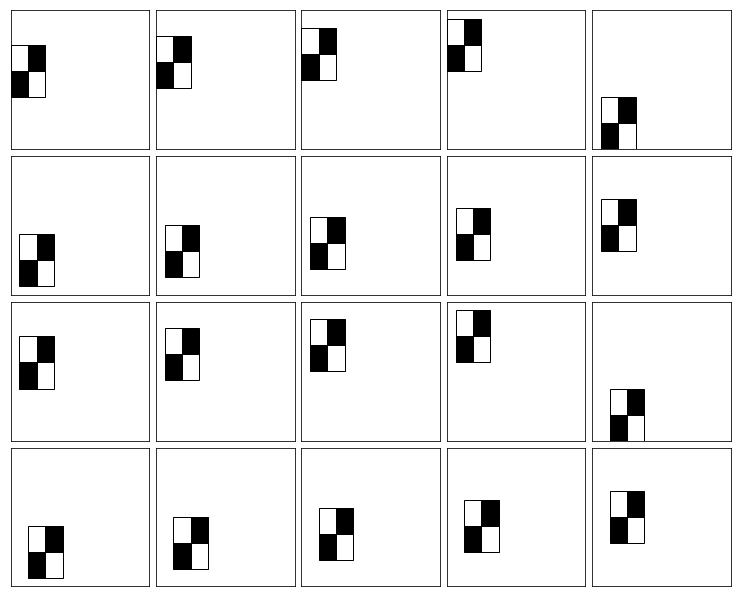

In [27]:
visualize_haar_filter(boost.weak_classifiers[900:920])

## Multiple weak classifiers as attributes of Boosting Classifier object

In [ ]:
print(boost.weak_classifiers[0].polarity)
print(boost.weak_classifiers[0].threshold)

print(boost.weak_classifiers[1].polarity)
print(boost.weak_classifiers[1].threshold)

In [ ]:
classifier_errors = boost.weak_classifier_errors(weights)

In [ ]:
print(boost.weak_classifiers[0].polarity)
print(boost.weak_classifiers[0].threshold)

print(boost.weak_classifiers[1].polarity)
print(boost.weak_classifiers[1].threshold)

In [ ]:
print(classifier_errors[0])
print(classifier_errors[1])

In [9]:
chosenWeakClassifiers = boost.train(chosen_wc_cache_dir)

  5%|▌         | 1/20 [00:04<01:30,  4.77s/it]

999
[0.205 0.21  0.21  0.215 0.21  0.215 0.215 0.22  0.215 0.235]


 10%|█         | 2/20 [00:11<01:35,  5.32s/it]

998
[0.28184606 0.27299109 0.26426426 0.26817913 0.25630637 0.28133345
 0.26830729 0.28235868 0.28499201 0.28576094]


 15%|█▌        | 3/20 [00:18<01:37,  5.72s/it]

997
[0.27693244 0.29566208 0.29237849 0.28271444 0.27528571 0.29252331
 0.27626389 0.27939087 0.29202697 0.29770247]


 20%|██        | 4/20 [00:24<01:36,  6.02s/it]

996
[0.30199514 0.30118069 0.30843325 0.31340655 0.31889888 0.3205134
 0.31458169 0.32101955 0.32310967 0.32371774]


 25%|██▌       | 5/20 [00:31<01:33,  6.25s/it]

995
[0.32462565 0.3246479  0.31614568 0.32637132 0.32885247 0.32175195
 0.32681318 0.3279694  0.3291579  0.33070296]


 30%|███       | 6/20 [00:38<01:30,  6.43s/it]

994
[0.31702299 0.32285723 0.31583163 0.32344887 0.32347026 0.3235927
 0.3249306  0.32814869 0.32887042 0.32970694]


 35%|███▌      | 7/20 [00:45<01:25,  6.57s/it]

993
[0.33405811 0.33069826 0.33737454 0.33971076 0.34044236 0.33806262
 0.33925726 0.33965108 0.34034971 0.34171379]


 40%|████      | 8/20 [00:52<01:20,  6.72s/it]

992
[0.32533822 0.33106513 0.32902964 0.32700342 0.3243832  0.33043475
 0.32654954 0.33155894 0.33646837 0.33673755]


 45%|████▌     | 9/20 [00:59<01:15,  6.82s/it]

991
[0.33992549 0.3407364  0.33290509 0.34585836 0.34491099 0.3383274
 0.34473314 0.34539191 0.34613324 0.3468608 ]


 50%|█████     | 10/20 [01:06<01:08,  6.89s/it]

990
[0.33719928 0.33799031 0.3383814  0.35064416 0.34626618 0.34572577
 0.34945158 0.35125733 0.35209018 0.35228596]


 55%|█████▌    | 11/20 [01:13<01:01,  6.86s/it]

989
[0.34633472 0.34512478 0.34244119 0.33506492 0.34945504 0.35054331
 0.35301247 0.35387668 0.3520575  0.35423282]


 60%|██████    | 12/20 [01:20<00:54,  6.86s/it]

988
[0.33824446 0.34510065 0.34793392 0.34636161 0.34246637 0.34970342
 0.35035455 0.35141234 0.35292267 0.35358729]


 65%|██████▌   | 13/20 [01:26<00:47,  6.84s/it]

987
[0.33352222 0.34409429 0.34796872 0.3460695  0.34870716 0.35067887
 0.35103646 0.35280461 0.35549027 0.35564598]


 70%|███████   | 14/20 [01:33<00:40,  6.83s/it]

986
[0.35160551 0.34285527 0.35018443 0.35014222 0.35207815 0.35433357
 0.35700746 0.35666477 0.3540975  0.35751018]


 75%|███████▌  | 15/20 [01:40<00:34,  6.82s/it]

985
[0.35465448 0.35117902 0.35650785 0.3600617  0.36046073 0.35997937
 0.35727398 0.35892279 0.36127733 0.36205914]


 80%|████████  | 16/20 [01:47<00:27,  6.83s/it]

984
[0.35524041 0.35358325 0.36105635 0.35369538 0.35417729 0.36151793
 0.35092938 0.36159951 0.36209722 0.362723  ]


 85%|████████▌ | 17/20 [01:54<00:20,  6.84s/it]

984
[0.34513614 0.34623132 0.34902303 0.35352178 0.35522444 0.35432453
 0.35621094 0.35778196 0.35893329 0.36053468]


 90%|█████████ | 18/20 [02:01<00:13,  6.82s/it]

983
[0.36136663 0.36364789 0.36472789 0.36339505 0.3633077  0.36356112
 0.36196151 0.35977387 0.36630631 0.36643985]


 95%|█████████▌| 19/20 [02:07<00:06,  6.86s/it]

982
[0.3578567  0.35785546 0.36001123 0.36978311 0.37000708 0.36671098
 0.36494202 0.36299711 0.37132157 0.37169812]


100%|██████████| 20/20 [02:14<00:00,  6.84s/it]

981
[0.36370817 0.36394663 0.36632935 0.36650064 0.36848381 0.3703361
 0.37134631 0.37136728 0.37141165 0.37144647]


In [28]:
boost.chosen_wcs

[[0.677666067757962, <weak_classifier.Ada_Weak_Classifier at 0x7f827f43fa90>],
 [0.5436284131555157, <weak_classifier.Ada_Weak_Classifier at 0x7f827f43fb38>],
 [0.4941523371147424, <weak_classifier.Ada_Weak_Classifier at 0x7f827f43fbe0>],
 [0.44500344924389135,
 [0.3987539501781452, <weak_classifier.Ada_Weak_Classifier at 0x7f827f43f9e8>],
 [0.4179837137510348, <weak_classifier.Ada_Weak_Classifier at 0x7f827f43f9b0>],
 [0.37503803375580347,
 [0.3862966876572736, <weak_classifier.Ada_Weak_Classifier at 0x7f827f43fd68>],
 [0.36341982760044245,
 [0.3404127861163678, <weak_classifier.Ada_Weak_Classifier at 0x7f827f43ff98>],
 [0.3446454869719465, <weak_classifier.Ada_Weak_Classifier at 0x7f827f43ffd0>],
 [0.34753394491792144,
 [0.3582703402808982, <weak_classifier.Ada_Weak_Classifier at 0x7f827f43fe80>],
 [0.32850764179278513,
 [0.31732326710637626,
 [0.3192650400379351, <weak_classifier.Ada_Weak_Classifier at 0x7f827f343160>],
 [0.3242568452916657, <weak_classifier.Ada_Weak_Classifier at 0

In [10]:
boost.visualizer.weak_classifier_accuracies

{0: array([0.205, 0.21 , 0.21 , 0.215, 0.21 , 0.215, 0.215, 0.22 , 0.215,
        0.235]),
 1: array([0.28184606, 0.27299109, 0.26426426, 0.26817913, 0.25630637,
        0.28133345, 0.26830729, 0.28235868, 0.28499201, 0.28576094]),
 2: array([0.27693244, 0.29566208, 0.29237849, 0.28271444, 0.27528571,
        0.29252331, 0.27626389, 0.27939087, 0.29202697, 0.29770247]),
 3: array([0.30199514, 0.30118069, 0.30843325, 0.31340655, 0.31889888,
        0.3205134 , 0.31458169, 0.32101955, 0.32310967, 0.32371774]),
 4: array([0.32462565, 0.3246479 , 0.31614568, 0.32637132, 0.32885247,
        0.32175195, 0.32681318, 0.3279694 , 0.3291579 , 0.33070296]),
 5: array([0.31702299, 0.32285723, 0.31583163, 0.32344887, 0.32347026,
        0.3235927 , 0.3249306 , 0.32814869, 0.32887042, 0.32970694]),
 6: array([0.33405811, 0.33069826, 0.33737454, 0.33971076, 0.34044236,
        0.33806262, 0.33925726, 0.33965108, 0.34034971, 0.34171379]),
 7: array([0.32533822, 0.33106513, 0.32902964, 0.32700342, 0.32

In [ ]:
boost.sc_function(boost.data[0])

In [ ]:
boost.set_strong_classifier_scores()

In [30]:
boost.visualizer.histogram_intervals = [1,10,20]
boost.visualizer.top_wc_intervals = [1,10,20]

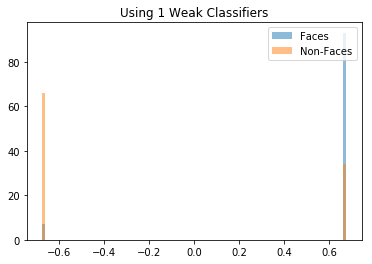

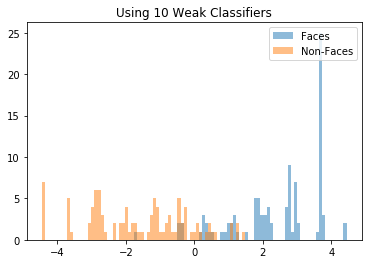

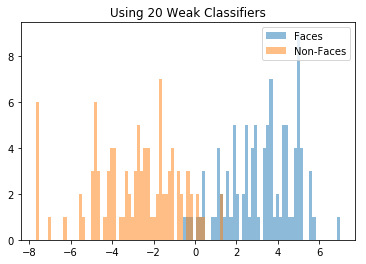

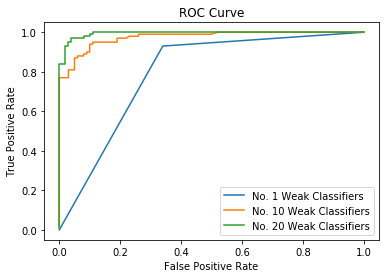

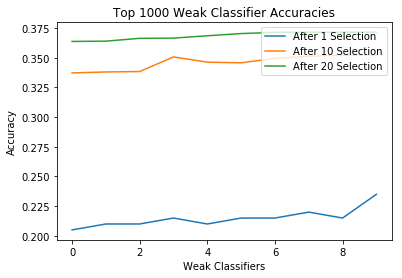

In [31]:
boost.visualize()

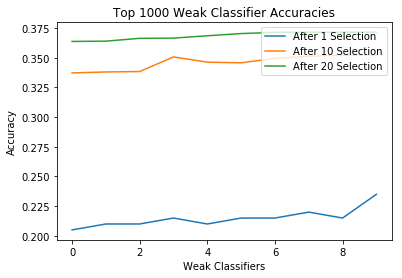

In [14]:
boost.visualizer.draw_wc_accuracies()

In [ ]:
boost.visualizer.weak_classifier_accuracies

In [ ]:
#original_img = cv2.imread('../Testing_Images/Face_1.jpg', cv2.IMREAD_GRAYSCALE)
#result_img = boost.face_detection(original_img)
#cv2.imwrite('Result_img_%s.png' % boosting_type, result_img)

## Toy example

In [ ]:
fltr_indices = [0, 100, 300, 500, 800]
toy_filters = [filters[i] for i in fltr_indices]#five filters
toy_data = np.vstack((np.array(data[0:5, :, :]), np.array(data[190:195, :, :]))) #10 images
l1 = list(labels[0:5])
l2 = list(labels[190:195])
toy_labels =  np.array(l1+ l2)  #10 labels

In [ ]:
toy_boost = Boosting_Classifier(toy_filters, toy_data, toy_labels, 4, num_bins, drawer, 1, "Ada")

In [ ]:
initial_toy_weights = [.1]*10
initial_toy_weights

In [ ]:
toy_boost.weak_classifiers[0]

In [ ]:
print(toy_boost.weak_classifiers[0].activations)

Setting up activations

In [ ]:
activations = toy_boost.calculate_training_activations("toy_act_dir.npy", "toy_act_dir.npy")

In [ ]:
print(activations.shape)
print(activations)

In [ ]:
toy_boost.weak_classifiers[0].activations

In [ ]:
print("Classifier 1:")
print("min error: ", toy_boost.weak_classifiers[0].calc_error(initial_toy_weights, toy_labels))
print("th: ", toy_boost.weak_classifiers[0].threshold)
print("pol: ", toy_boost.weak_classifiers[0].polarity)

print("Classifier 2:")
print("min error: ", toy_boost.weak_classifiers[1].calc_error(initial_toy_weights, toy_labels))
print("th: ", toy_boost.weak_classifiers[1].threshold)
print("pol: ", toy_boost.weak_classifiers[1].polarity)

print("Classifier 3:")
print("min error: ", toy_boost.weak_classifiers[2].calc_error(initial_toy_weights, toy_labels))
print("th: ", toy_boost.weak_classifiers[2].threshold)
print("pol: ", toy_boost.weak_classifiers[2].polarity)

print("Classifier 4:")
print("min error: ", toy_boost.weak_classifiers[3].calc_error(initial_toy_weights, toy_labels))
print("th: ", toy_boost.weak_classifiers[3].threshold)
print("pol: ", toy_boost.weak_classifiers[3].polarity)

print("Classifier 5:")
print("min error: ", toy_boost.weak_classifiers[4].calc_error(initial_toy_weights, toy_labels))
print("th: ", toy_boost.weak_classifiers[4].threshold)
print("pol: ", toy_boost.weak_classifiers[4].polarity)

In [ ]:
print(toy_boost.labels == 1) #correct labels
for classifier in toy_boost.weak_classifiers:
    print(classifier.activations*classifier.polarity > classifier.threshold*classifier.polarity)

In [ ]:
initial_toy_weights

calculate all weak classifier errors using the weighted data

In [ ]:
min_error = [classifier.calc_error(initial_toy_weights, toy_boost.labels)for classifer in toy_boost.weak_classifiers]
print("min error: ", min_error)    

select the best weak classifier

In [ ]:
import copy
bestWCIndex = min_error.index(min(min_error))
bestWClassifier = copy.deepcopy(toy_boost.weak_classifiers[bestWCIndex])
print(bestWClassifier)
print(bestWClassifier.polarity)
print(bestWClassifier.threshold)

In [ ]:
selectedWC = []

calculate alpha value

In [ ]:
alph = toy_boost.calculate_alpha(min(min_error))
selectedWC.append([alph, bestWClassifier])
print("alpha: ", alph)

In [ ]:
#check, the error is .3, plug into the formula for alpha
.5*(np.log((1-.3)/.3))

In [ ]:
#for bestWC, which data points did it incorrectly classify?
print(toy_boost.labels == 1) #correct labels
print(bestWClassifier.activations*bestWClassifier.polarity > bestWClassifier.threshold*bestWClassifier.polarity)

In [ ]:
initial_toy_weights

In [ ]:
weights = toy_boost.update_weights(bestWClassifier, initial_toy_weights, alph)

In [ ]:
weights

In [ ]:
min_error_2 = [classifier.calc_error(weights, toy_boost.labels)for classifer in toy_boost.weak_classifiers]
print("min error: ", min_error_2 )
    
bestWCIndex = min_error_2.index(min(min_error_2))
bestWClassifier = copy.deepcopy(toy_boost.weak_classifiers[bestWCIndex])
print(bestWClassifier)
print(bestWClassifier.polarity)
print(bestWClassifier.threshold)

In [ ]:
toy_boost.train()

In [ ]:
[toy_boost.sc_function(img) for img in toy_boost.data]

In [ ]:
toy_boost.set_strong_classifier_scores

In [ ]:
toy_boost.visualizer.strong_classifier_scores

Perform hard mining after all the training epochs are over, using the final strong classifier to get the wrong patches, and then restart the training process with the added wrong patches?